# Assignment 2 BRAINS

# Problem 1:Trade Logic & Risk Control Basics

**1. What does leverage less than 1 mean? Does it normally make financial sense? Think of its utility/applicability in our backtesting engine, if any. (Hint: Think of position sizing)**

A leverage ratio is a type of financial measurement used to evaluate the level of debt relative to another financial metric. It is used to assess a company's financial obligations.

A leverage ratio like debt-to-equity less than 1 indicates that the company is not highly reliant on debts and has more equity than debt.

Leverage <1 is indicative of lower risk as we are not investing our full capital and keeping it reserved. 

In terms of its utility, it helps in risk management by
- limiting the amount of capital at risk for each trade
- allows in the modelling of scenarios where one does not invest the complete amount 


**2. Explain the difference between a static stop loss and a trailing stop loss in the context of trade risk management. Discuss how each behaves in trending market versus a volatile market.**

Fixed stoploss orders specify a set stop price below the current market price of a security. 

Trailing stoploss orders follow the market price of a security as it rises and update the stop price accordingly

The main difference: A static stoploss remains constant while a trailing stoploss moves according to the price movements. 

In a trending Market:<br>
Static stoploss, being constant, may get triggered early on leading to potential loss of profits.<br>
Trailing stoploss adjusts accordingly to the price movement leading to better profits.

In a volatile market:<br>
Static stoploss provides a clear exit point.
Trailing stoploss would be repeatedly triggered due to fluctuations in the price trends leading to early exits.

**3. Analyze whether implementing a trailing take profit is necessary. Is its behavior cap
tured by some other already defined risk management method? If yes, then name it.**

A trailing take-profit helps in gaining maximum profit and adjusts itseld accordingly like trailing stoploss. The trailing stoploss is already doing that job by exiting a trade if we're losing above a certain margin and thereby protecting our profits. 
Therefore, either stoploss or take-profit should be used as their domain of interest overlaps.


**4. In what scenarios can a trade remain open even after the price falls below the set stop-loss level?**

If stoploss is implemenmted, the order takes place only when it hits that particular price-point. It is possible the stock does not touch that point and jumps to a much lower price but the trade has to be executed at the next available price. In that case, the trade would technically remain open and would lead to a much greater loss.

Also, if the price decreases too quickly, before the trailing stoploss has time to adjust itself, it might be possible that the trade still remains open.

#  Problem Statement 2: Probabilistic Pattern Validator

## Importing Necessary Libraries

In [46]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import matplotlib.pyplot as plt
import statistics

## Downloading the data

In [47]:
def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)

    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data.loc[:,'datetime'] = pd.to_datetime(data['datetime'])

    return data

stock_symbol = 'LT.NS'
data = download_flat_yf(stock_symbol, start='2020-06-01', end='2025-06-01', interval='1d')
data.head()

,datetime,close,high,low,open,volume
0,2020-06-01,850.819397,892.986817,847.015140,865.944667,7617144
1,2020-06-02,866.678040,873.598986,836.977485,857.098690,7325471
2,2020-06-03,881.207397,891.795075,875.432305,876.303166,4651554
3,2020-06-04,853.156921,887.349188,851.231853,880.978229,5355931
4,2020-06-05,875.661499,879.924098,858.565337,861.682082,6071040


<b>Information about the data

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  1240 non-null   datetime64[ns]
 1   close     1240 non-null   float64       
 2   high      1240 non-null   float64       
 3   low       1240 non-null   float64       
 4   open      1240 non-null   float64       
 5   volume    1240 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 58.3 KB


<b>Candlestick chart of LT.NS

In [49]:
fig = go.Figure(data=[
    go.Candlestick(x=data['datetime'],
                   open=data['open'],
                   high=data['high'],
                   low=data['low'],
                   close=data['close'])
              ])
fig.update_layout(title=f"Candlestick Chart - {stock_symbol}", xaxis_title='Date', yaxis_title='Price')
fig.show()

## Functions for different candlestick patterns

In [50]:
def is_bullish_engulfing(data, i):
    prev = data.iloc[i - 1]
    curr = data.iloc[i]
    return (
        prev['close'] < prev['open'] and
        curr['close'] > curr['open'] and
        curr['open'] < prev['close'] and
        curr['close'] > prev['open']
    )

def is_bearish_engulfing(data, i):
    prev = data.iloc[i - 1]
    curr = data.iloc[i]
    return (
        prev['close'] > prev['open'] and
        curr['close'] < curr['open'] and
        curr['open'] > prev['close'] and
        curr['close'] < prev['open']
    )

def is_doji(data, i):
    body = abs(data.iloc[i]['open'] - data.iloc[i]['close'])
    range_ = data.iloc[i]['high'] - data.iloc[i]['low'] + 1e-9
    return body / range_ < 0.1

def is_hammer(data, i):
    body = abs(data.iloc[i]['open'] - data.iloc[i]['close'])
    lower_shadow = data.iloc[i]['open'] - data.iloc[i]['low']
    upper_shadow = data.iloc[i]['high'] - data.iloc[i]['close']
    return (
        body < 0.3 * (data.iloc[i]['high'] - data.iloc[i]['low']) and
        lower_shadow > 2 * body and
        upper_shadow < body
    )


<b>Total Count of patterns

In [51]:
patterns={"Doji":[], "Hammer":[], "Bullish Engulfing":[], "Bearish Engulfing":[]}
for i in range(1, len(data)):
    if is_doji(data, i):
        patterns["Doji"].append(data.index[i])
    if is_hammer(data, i):
        patterns["Hammer"].append(data.index[i])
    if is_bullish_engulfing(data, i):
        patterns["Bullish Engulfing"].append(data.index[i])
    if is_bearish_engulfing(data, i):
        patterns["Bearish Engulfing"].append(data.index[i])

print("Patterns found:")
print(f"Doji: {len(patterns['Doji'])}")
print(f"Hammer: {len(patterns['Hammer'])}")
print(f"Bullish Engulfing: {len(patterns['Bullish Engulfing'])}")
print(f"Bearish Engulfing: {len(patterns['Bearish Engulfing'])}")

Patterns found:
Doji: 98
Hammer: 20
Bullish Engulfing: 33
Bearish Engulfing: 69


## Win-Rate Calculation

In [52]:
# Function to calculate win-rate
def calculate_win_rate(indexes, n, df):
    wins = 0
    for i in indexes:
        if i + n < len(df):
            returns = df.iloc[i + n]["close"] - df.iloc[i]["close"]
            if returns > 0:
                wins += 1
    return 100 * wins / len(indexes) if indexes else 0

## Baseline Win-Rate Calculation

In [53]:
import random
def baseline_win_rate(count, n, data):
    wins = 0
    M=range(len(data) - n)
    indices = random.sample(M, count)
    for i in indices:
        returns = data.iloc[i+n]['close'] - data.iloc[i]['close']
        if returns > 0 and i + n < len(data):
            wins += 1
    return (wins / count) * 100

## Final Win-rates and Visualization

In [54]:
n_vals=[3,5]
results={}

for n in n_vals:
    pattern_results={}
    for pattern, indexes in patterns.items():
        win_rate = calculate_win_rate(indexes, n, data)
        pattern_results[pattern] = win_rate
    baseline_rate = baseline_win_rate(len(patterns['Bullish Engulfing']), n, data)
    pattern_results['Baseline'] = baseline_rate
    results[n] = pattern_results

print("Win Rates:") 
for n, rates in results.items():
    print(f"n={n}:")
    for pattern, rate in rates.items():
        print(f"  {pattern}: {rate:.2f}%")

Win Rates:
n=3:
  Doji: 53.06%
  Hammer: 55.00%
  Bullish Engulfing: 57.58%
  Bearish Engulfing: 57.97%
  Baseline: 54.55%
n=5:
  Doji: 63.27%
  Hammer: 60.00%
  Bullish Engulfing: 72.73%
  Bearish Engulfing: 62.32%
  Baseline: 54.55%


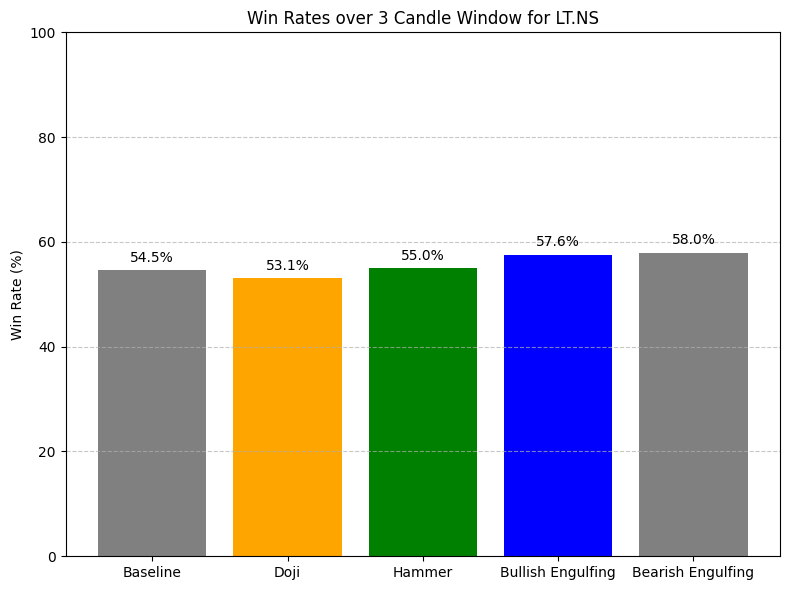

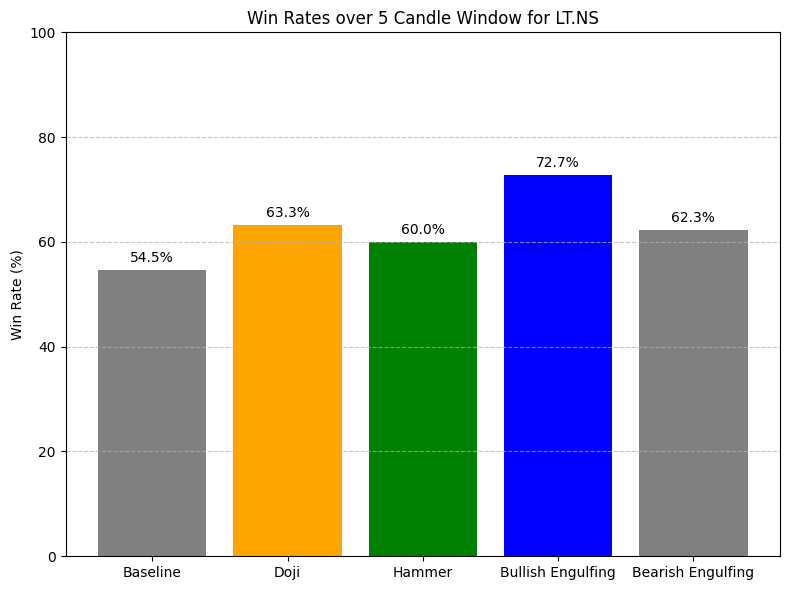

In [55]:
#Visualization
for n in n_vals:
    labels = ['Baseline', 'Doji', 'Hammer', 'Bullish Engulfing', 'Bearish Engulfing']
    values = [results[n][label] for label in labels]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color=['gray', 'orange', 'green', 'blue'])
    plt.title(f'Win Rates over {n} Candle Window for {stock_symbol}')
    plt.ylabel('Win Rate (%)')
    plt.ylim(0, 100)
    for i, val in enumerate(values):
        plt.text(i, val + 1, f"{val:.1f}%", ha='center', va='bottom')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

<b>

1. Interpret whether each pattern provides a statistically significant edge over the baseline.
2. How does changing n affect the win-rates? No need to show your results. Answer qualitatively.
3. Which pattern shows the most consistent performance on different n? Why would that be? 

Taking into account these results:

n=3:
- Doji: 53.06%                      
- Hammer: 55.00%                    
- Bullish Engulfing: 57.58%         
- Bearish Engulfing: 57.97%         
- Baseline: 51.52%                  

n=5:
- Doji: 63.27%
- Hammer: 60.00%
- Bullish Engulfing: 72.73%
- Bearish Engulfing: 62.32%
- Baseline: 75.76%

For n = 3, all patterns were just slightly better than the baseline (51.52%). Bullish and Bearish Engulfing patterns showed the best win-rates of 57.58% and 57.97%, respectively.

However, for n = 5, the baseline win-rate jumped to 75.76%, likely due to a general bullish trend in the stock over the 5-year period, making random long entries more favorable over a longwer period of time. The general bullish trend can be seen below.
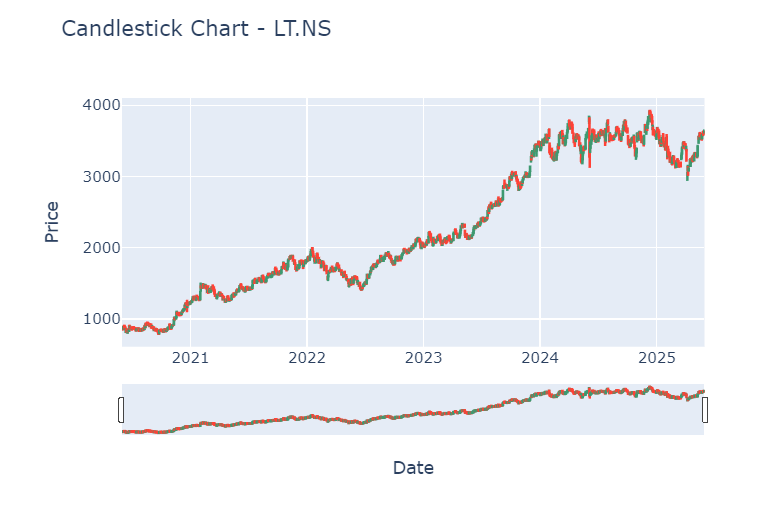

While all the patterns still showed positive win-rates (e.g., Bullish Engulfing at 72.73%), none of them managed to perform better than the baseline for n=5.

This shows that the edge of candlestick patterns is more significant over shorter periods of time. As we extend the window period, market noise and trend-following behavior dominate, reducing the performance of only pattern-based signals.

#  Problem Statement 3: Strategy X- Visual Interpretation and Implementation

## **1. Chart Interpretation:**

The indicators in the strategy X are:
- Heiken Ashi candles: Help in visualization by smoothing out price fluctuations and help in indentifying trends
- Supertrend Indicator: Helps in determining trend direction.
    - Red Band = Downtrend
    - Green Band = Uptrend
- Money Flow Index (MFI): Uses price changes and trading volume to create a fuller picture of market sentiment than price-only indicators.
    - Overbought: >80
    - Oversold: <20
    - Graph moving up: buying pressure
    - Graoh moving down: selling pressure

Visualizations and markings:
1. Trend Arrows (UPTREND/DOWNTREND): 
    - green for uptrend and red for downtrend
2. Using MFI and Supertrend
    - When supertrend band is green, MFI is rising: Buying pressure, UPTREND
    - When supertrend band is red, MFI is falling: selling pressure, DOWNTREND
    - Sideways: Supertrend is flat and MFI is also not moving, no pressure

Trading Logic:
1. Supertrend: 
- Red band: bearish
- Green band: bullish
- Sideways: no movement
2. MFI
- Rising MFI: bullish
- Falling MFI: bearish

## 2. **Entry and Exit Rules**

**Entry Conditions:**

- Long Entry:
    - Supertrend is bullish (supertrend_direction == 1)
    - MFI increasing from a lower zone
    - MFI slope is positive
    - MFI<80 (not in overbought)
    - Close > Supertrend line

- Short Entry:
    - Supertrend is bearish (supertrend_direction == -1)
    - Close < Supertrend line
    - MFI is falling or drops from overbought

**Exit Conditions:**

- Exit Long:
    - Supertrend turns red
    - MFI slope negative
    - MFI>80 (in overbought)

- Exit Short:
    - Supertrend turns green
    - MFI slope turns positive
    - MFI<20 (oversold)

Additional/alternative rule:
- Use a trailing stop-loss to prevent loss from sudden trend reversals
- Add a waiting window if 1-2 candles after supertrend changes to prevent false signals 

## **3. Strategy Implementation and Backtest**

### Backtest Engine

In [56]:
#@title Backtest Engine
def perform_backtest(dataframe, lev=1, initial_capital=100000 , lot_size=1, tsl=100):
    """
    Backtesting engine for trading strategies.

    Parameters:
    - dataframe: Pandas DataFrame with columns ['timestamp', 'close', 'high', 'signals']
                 signals: 1 for long entry/close short, -1 for short entry/close long, 0 no action
    - lev: Leverage multiplier for position sizing (default 1)
    - initial_capital: Starting capital for backtest (default 100000)
    - lot_size: Number of units per lot (default 1)
    - tsl: Trailing stop loss percentage (default 100%)

    Returns:
    - trade_log: DataFrame summarizing all trades with entry/exit dates, profit/loss, size and type
    """
    capital_list = [initial_capital]
    trade = 0  # 0 = no open trade, 1 = long trade open, -1 = short trade open
    position_size = 0
    trade_profit = []
    entry, exit = [], []
    entry_index, exit_index = [], []
    nol, nos = 0, 0  # Number of long and short trades
    long_profit, short_profit = [], []
    trade_type = []
    position_size_list = []

    # Calculate benchmark returns over entire backtest period
    benchmark_returns = (dataframe.loc[dataframe.index[-1], 'close'] / dataframe.loc[dataframe.index[0], 'close'] - 1) * 100

    # Calculate backtest period in years and months
    backtest_period = dataframe.loc[dataframe.index[-1], 'timestamp'] - dataframe.loc[dataframe.index[0], 'timestamp']
    total_days = backtest_period.days
    years = total_days // 365
    remaining_days = total_days % 365
    months = remaining_days // 30

    max_price = 0  # For tracking trailing stop price

    for i in range(len(dataframe)):
        date = dataframe.loc[i, 'timestamp']
        current_price = dataframe.loc[i, 'close']
        high_price = dataframe.loc[i, 'high']

        # Stop if capital is exhausted
        if capital_list[-1] <= 0:
            print(f'Complete capital lost on {date}')
            break

        # Open Long trade if no trade is open and signal is long (1)
        if trade == 0 and dataframe.loc[i, 'signals'] == 1:
            position_size = (capital_list[-1] * lev) // (current_price * lot_size)
            cost = position_size * current_price * lot_size
            if cost > 0:
                position_size_list.append(position_size * lot_size)
                trade = 1
                entry.append(date)
                entry_index.append(i)
                max_price = current_price  # Initialize max price for trailing stop
            else:
                position_size = 0

        # Open Short trade if no trade is open and signal is short (-1)
        elif trade == 0 and dataframe.loc[i, 'signals'] == -1:
            position_size = (capital_list[-1] * lev) // (current_price * lot_size)
            cost = position_size * current_price * lot_size
            if cost > 0:
                position_size_list.append(position_size * lot_size)
                trade = -1
                entry.append(date)
                entry_index.append(i)
                max_price = current_price  # Initialize min price for trailing stop (will update below)
            else:
                position_size = 0

        # Manage open trade and trailing stop
        elif trade != 0:
            if trade == 1:
                # Update max price seen during long trade for trailing stop loss
                max_price = max(max_price, high_price)
                # Check if current close triggers trailing stop loss exit
                if dataframe.loc[i, 'close'] <= (1 - tsl / 100) * max_price:
                    # Set signal to close long and open short (or just close)
                    dataframe.loc[i, 'signals'] = -1  # force exit long
                    max_price = 0

            elif trade == -1:
                # For short, track minimum price for trailing stop loss
                max_price = min(max_price, high_price)
                # Check if current close triggers trailing stop loss exit
                if dataframe.loc[i, 'close'] >= (1 + tsl / 100) * max_price:
                    dataframe.loc[i, 'signals'] = 1  # force exit short
                    max_price = 0

            # If signal indicates closing current trade (opposite signal)
            if dataframe.loc[i, 'signals'] * trade == -1:
                exit.append(date)
                exit_index.append(i)
                if trade == 1:
                    nol += 1
                    profit = lot_size * current_price * position_size - cost
                else:
                    nos += 1
                    profit = cost - lot_size * current_price * position_size

                capital_list.append(capital_list[-1] + profit)
                trade_profit.append(profit)

                if trade == 1:
                    long_profit.append(profit)
                else:
                    short_profit.append(profit)

                trade_type.append('Long' if trade == 1 else 'Short')
                trade = 0
                position_size = 0
                cost = 0

    # Close any open trade at last price in dataframe
    if trade != 0:
        exit.append(dataframe.iloc[-1]['timestamp'])
        exit_index.append(len(dataframe) - 1)
        if trade == 1:
            nol += 1
            profit = dataframe.iloc[-1]['close'] * position_size * lot_size - cost
            trade_type.append('Long')
        else:
            nos += 1
            profit = cost - dataframe.iloc[-1]['close'] * position_size * lot_size
            trade_type.append('Short')
        capital_list.append(capital_list[-1] + profit)
        trade_profit.append(profit)

    # Calculate returns for performance metrics
    returns = np.diff(capital_list) / capital_list[:-1]
    downside_returns = returns[returns < 0]

    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if len(returns) > 0 and np.std(returns) > 0 else float('nan')
    sortino_ratio = np.mean(returns) / np.std(downside_returns) * np.sqrt(252) if len(downside_returns) > 0 and np.std(downside_returns) > 0 else float('nan')

    number_of_trades = len(trade_profit)

    capital_series = pd.Series(capital_list)
    running_max = capital_series.cummax()
    drawdowns = (capital_series - running_max) / running_max
    drawdowns = drawdowns[drawdowns <= 0]

    print(f'BACKTEST RESULTS:')
    if number_of_trades == 0:
        print('No trades taken')
        return

    print(f"Backtest Period: {years} years and {months} months")
    print(f'Benchmark Returns: {benchmark_returns * lev:.2f} %')
    print(f'Initial Capital: {capital_list[0]}')
    print(f'Final Capital: {capital_list[-1]:.2f}')
    print(f'Profit percentage: {(capital_list[-1] - capital_list[0]) / capital_list[0] * 100:.2f} %')
    print(f'Leverage applied: {lev}')
    print(f'Maximum Portfolio balance: {max(capital_list):.2f}')
    print(f'Minimum Portfolio balance: {min(capital_list):.2f}')
    print(f'Number of trades: {number_of_trades}')

    win = sum(1 for profit in trade_profit if profit > 0)
    print(f'Winning Trades: {win}')
    print(f'Losing Trades: {number_of_trades - win}')
    print(f'Win Rate: {win / number_of_trades * 100:.2f} %')

    try:
        avg_profit = statistics.mean([x for x in trade_profit if x > 0])
    except:
        avg_profit = 0
    try:
        avg_loss = statistics.mean([x for x in trade_profit if x <= 0])
    except:
        avg_loss = 0

    print(f'Average Profit: {avg_profit:.2f}')
    print(f'Average Loss: {avg_loss:.2f}')
    print(f'No of Long Trades: {nol}')
    print(f'No of Short Trades: {nos}')
    print(f'Average drawdown: {np.mean(drawdowns) * 100:.2f} %')
    print(f'Maximum drawdown: {np.min(drawdowns) * 100:.2f} %')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print(f'Sortino Ratio: {sortino_ratio:.2f}')

    # Calculate and print holding times if any trades happened
    if entry and exit:
        holding_times = [(exit[i] - entry[i]) for i in range(len(entry))]
        max_holding_time = max(holding_times)
        days = max_holding_time.days
        hours, remainder = divmod(max_holding_time.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f'Maximum Holding Time: {days} days, {hours:02}:{minutes:02}:{seconds:02}')

        avg_holding_time = sum(holding_times, pd.Timedelta(0)) / len(holding_times)
        days_avg = avg_holding_time.days
        hours_avg, remainder_avg = divmod(avg_holding_time.seconds, 3600)
        minutes_avg, seconds_avg = divmod(remainder_avg, 60)
        print(f'Average Holding Time: {days_avg} days, {hours_avg:02}:{minutes_avg:02}:{seconds_avg:02}')

    # Plotting equity curve and price chart with entry/exit points
    fig = sp.make_subplots(
        rows=2, cols=1, shared_xaxes=True,
        subplot_titles=('Equity Curve', 'Price Action with Entry and Exit Points'),
        vertical_spacing=0.1
    )

    # Equity Curve
    fig.add_trace(go.Scatter(
        y=capital_list,
        mode='lines',
        name='Capital',
        line=dict(color='green')
    ), row=1, col=1)

    # Price chart
    fig.add_trace(go.Scatter(
        x=dataframe['timestamp'],
        y=dataframe['close'],
        mode='lines',
        name='Close Price',
        line=dict(color='blue')
    ), row=2, col=1)

    # Entry markers
    fig.add_trace(go.Scatter(
        x=[dataframe['timestamp'].iloc[i] for i in entry_index],
        y=[dataframe['close'].iloc[i] for i in entry_index],
        mode='markers',
        marker=dict(symbol='triangle-up', color='green', size=10),
        name='Entry'
    ), row=2, col=1)

    # Exit markers
    fig.add_trace(go.Scatter(
        x=[dataframe['timestamp'].iloc[i] for i in exit_index],
        y=[dataframe['close'].iloc[i] for i in exit_index],
        mode='markers',
        marker=dict(symbol='triangle-down', color='red', size=10),
        name='Exit'
    ), row=2, col=1)

    fig.update_layout(
        height=800,
        title_text='Backtest Visualizations',
        showlegend=True,
        template='plotly_white'
    )

    fig.update_xaxes(title_text='Time', row=2, col=1)
    fig.update_yaxes(title_text='Capital', row=1, col=1)
    fig.update_yaxes(title_text='Price', row=2, col=1)

    fig.show()

    # Prepare trade log DataFrame
    trade_log = pd.DataFrame({
        'Entry Candle': entry,
        'Exit Candle': exit,
        'PnL': trade_profit,
        'Number of units': position_size_list,
        'Trade type': trade_type
    })

    return trade_log

### Downloading the Data

In [57]:
def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval,
    progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)
    
    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data['datetime'] = pd.to_datetime(data['datetime'])
    return data
stock_symbol1 = 'CAMS.NS'
df = download_flat_yf(stock_symbol1, start='2024-01-01', end='2025-05-04', interval='1d')
df.head()

,datetime,close,high,low,open,volume
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141
2,2024-01-03,2602.318604,2635.385987,2599.767311,2620.569327,112428
3,2024-01-04,2657.512695,2693.229349,2620.863682,2624.788600,268532
4,2024-01-05,2696.565430,2716.042929,2661.290281,2674.095373,354882


<b>Candlestick chart of CAMS.NS

In [58]:
fig1 = go.Figure(data=[
    go.Candlestick(x=df['datetime'],
                   open=df['open'],
                   high=df['high'],
                   low=df['low'],
                   close=df['close'])
              ])
fig1.update_layout(title=f"Candlestick Chart - {stock_symbol1}", xaxis_title='Date', yaxis_title='Price')
fig1.show()

### Heiken Ashi Denoising

In [59]:
def apply_heiken_ashi(data):
    ha_data = data.copy()
    # Initialize Heiken-Ashi columns
    ha_data['ha_close'] = (data['open'] + data['high'] + data['low'] + data['close']) / 4
    ha_open = [(data['open'].iloc[0] + data['close'].iloc[0])/2]
    for i in range(1, len(data)):
        ha_open.append((ha_open[i-1] + ha_data['ha_close'].iloc[i-1]) / 2)

    ha_data['ha_open'] = ha_open
    ha_data['ha_high'] = ha_data[['ha_open', 'ha_close', 'high']].max(axis=1)
    ha_data['ha_low'] = ha_data[['ha_open', 'ha_close', 'low']].min(axis=1)

    # Replace original OHLC with Heiken-Ashi values
    ha_data['open'] = ha_data['ha_open']
    ha_data['close'] = ha_data['ha_close']
    ha_data['high'] = ha_data['ha_high']
    ha_data['low'] = ha_data['ha_low']

    return ha_data.drop(columns=['ha_open', 'ha_close', 'ha_high', 'ha_low'])

In [60]:
df_ha = df.copy()
df_ha = apply_heiken_ashi(df_ha)

In [61]:
df_combined = df_ha.copy()
df_combined = df_combined.merge(df[['datetime', 'close','open','high','low']], on='datetime', how='left', suffixes=('', '_main'))

In [62]:
df_combined.head()

,datetime,close,high,low,open,volume,close_main,open_main,high_main,low_main
0,2024-01-01,2607.077533,2626.751171,2593.683788,2603.937587,66066,2598.786133,2609.089042,2626.751171,2593.683788
1,2024-01-02,2617.490805,2644.413287,2600.797687,2605.507560,143141,2619.588135,2605.164110,2644.413287,2600.797687
2,2024-01-03,2614.510307,2635.385987,2599.767311,2611.499183,112428,2602.318604,2620.569327,2635.385987,2599.767311
3,2024-01-04,2649.098581,2693.229349,2613.004745,2613.004745,268532,2657.512695,2624.788600,2693.229349,2620.863682
4,2024-01-05,2686.998503,2716.042929,2631.051663,2631.051663,354882,2696.565430,2674.095373,2716.042929,2661.290281


<b>Candlestick chart of CAMS.NS with Heiken Ashi Denoising

In [63]:
fig_ha = go.Figure(data=[
    go.Candlestick(x=df_combined['datetime'],
                   open=df_combined['open'],
                   high=df_combined['high'],
                   low=df_combined['low'],
                   close=df_combined['close'])
              ])
fig_ha.update_layout(title=f"Candlestick Chart with Heiken Ashi Denoising - {stock_symbol1}", xaxis_title='Date', yaxis_title='Price')
fig_ha.show()

### Supertrend Indicator Calculation

I tried to implement supertrend via python code but was getting errors. The help code I used was:
Sourcecode: https://eodhd.com/financial-academy/backtesting-strategies-examples/a-step-by-step-guide-to-implementing-the-supertrend-indicator-in-python

In [64]:
# def get_supertrend(high, low, close, lookback=10, multiplier=3):
#     import numpy as np
#     import pandas as pd

#     # Step 1: True Range & ATR
#     tr1 = high - low
#     tr2 = abs(high - close.shift(1))
#     tr3 = abs(low - close.shift(1))
#     tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
#     atr = tr.ewm(span=lookback, adjust=False).mean()

#     # Step 2: Basic Upper and Lower Bands
#     hl2 = (high + low) / 2
#     upper_band = hl2 + multiplier * atr
#     lower_band = hl2 - multiplier * atr

#     # Step 3: Final Bands
#     final_upperband = upper_band.copy()
#     final_lowerband = lower_band.copy()

#     for i in range(1, len(close)):
#         if (close[i - 1] > final_upperband[i - 1]):
#             final_upperband[i] = upper_band[i]
#         else:
#             final_upperband[i] = min(upper_band[i], final_upperband[i - 1])

#         if (close[i - 1] < final_lowerband[i - 1]):
#             final_lowerband[i] = lower_band[i]
#         else:
#             final_lowerband[i] = max(lower_band[i], final_lowerband[i - 1])

#     # Step 4: Supertrend & Direction
#     supertrend = pd.Series(index=close.index, dtype='float64')
#     direction = pd.Series(index=close.index, dtype='int')

#     for i in range(1, len(close)):
#         if (supertrend[i - 1] == final_upperband[i - 1] and close[i] <= final_upperband[i]):
#             supertrend[i] = final_upperband[i]
#         elif (supertrend[i - 1] == final_upperband[i - 1] and close[i] > final_upperband[i]):
#             supertrend[i] = final_lowerband[i]
#         elif (supertrend[i - 1] == final_lowerband[i - 1] and close[i] >= final_lowerband[i]):
#             supertrend[i] = final_lowerband[i]
#         elif (supertrend[i - 1] == final_lowerband[i - 1] and close[i] < final_lowerband[i]):
#             supertrend[i] = final_upperband[i]
#         else:
#             supertrend[i] = np.nan  # initialization for first row, etc.

#         direction[i] = 1 if close[i] > supertrend[i] else -1

#     # Clean up first row
#     supertrend.iloc[0] = np.nan
#     direction.iloc[0] = 0

#     # Format like pandas_ta
#     df = pd.DataFrame({
#         f"SUPERT_{lookback}_{multiplier}": supertrend,
#         f"SUPERTd_{lookback}_{multiplier}": direction
#     })

#     return df


In [65]:
import pandas_ta as ta

supertrend= ta.supertrend(df_combined['high'], df_combined['low'], df_combined['close'], length=10, multiplier=3)
df_combined['supertrend']= supertrend['SUPERT_10_3.0']
df_combined['supertrend_direction']=supertrend['SUPERTd_10_3.0']
df_combined['supertrend_flip'] = df_combined['supertrend_direction'].diff()

<b>Visulatization of Supertrend on Heiken Ashi Candles

In [66]:
# Heiken Ashi Candlestick chart
fig = go.Figure(data=[
    go.Candlestick(
        x=df_combined.index,
        open=df_combined['open'],
        high=df_combined['high'],
        low=df_combined['low'],
        close=df_combined['close'],
        name='Candlestick')])

# Green for Uptrend
fig.add_trace(go.Scatter(
    x=df_combined.index,
    y=df_combined['supertrend'].where(df_combined['supertrend_direction'] == 1),
    mode='lines',
    line=dict(color='green', width=2),
    name='UPTREND'))

# Red for Downtrend
fig.add_trace(go.Scatter(
    x=df_combined.index,
    y=df_combined['supertrend'].where(df_combined['supertrend_direction'] == -1),
    mode='lines',
    line=dict(color='red', width=2),
    name='DOWNTREND'))

fig.update_layout(
    title='Heiken Ashi Candlestick Chart with Supertrend Indicator',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    height=700)

fig.show()


### MFI Indicator Calculation

In [67]:
import ta
from ta.volume import MFIIndicator

# MFI calculation on the original OHLCV data
mfi = MFIIndicator(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=14)
df_combined['mfi'] = mfi.money_flow_index()
df_combined['mfi_slope']=df_combined['mfi'].diff(3)

<b>Visualization of MFI

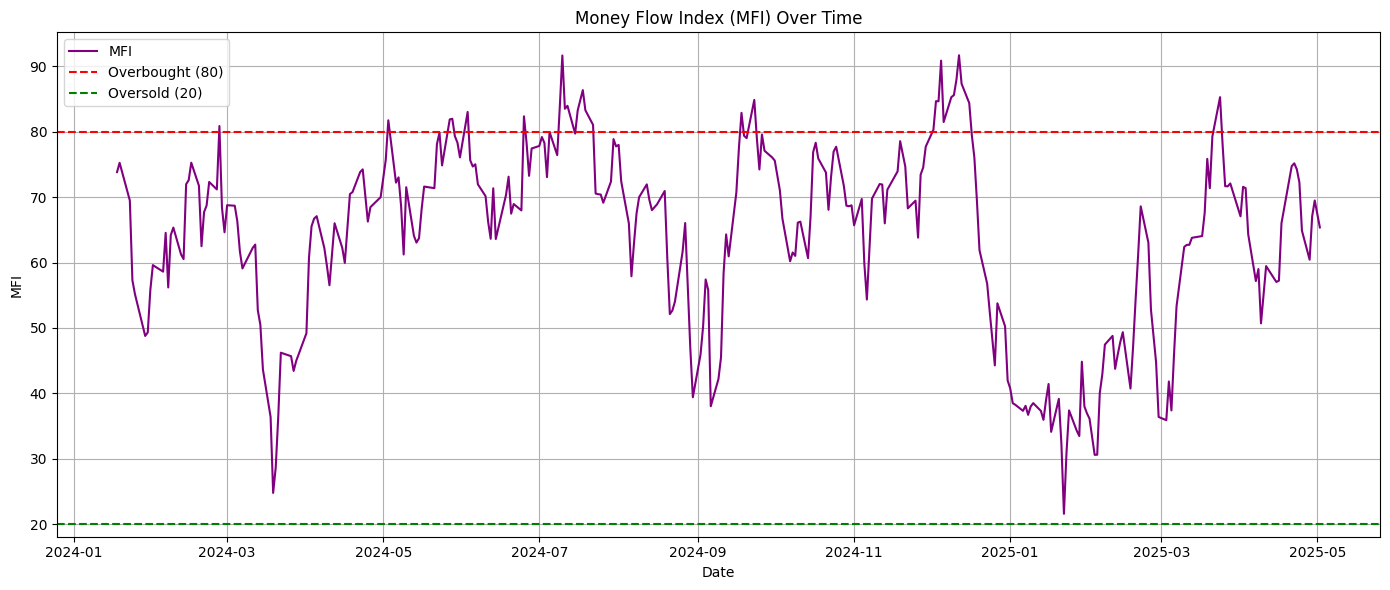

In [68]:
plt.figure(figsize=(14, 6))
plt.plot(df_combined['datetime'], df_combined['mfi'], label='MFI', color='purple')

# Highlight overbought and oversold zones
plt.axhline(80, color='red', linestyle='--', label='Overbought (80)')
plt.axhline(20, color='green', linestyle='--', label='Oversold (20)')

plt.title('Money Flow Index (MFI) Over Time')
plt.xlabel('Date')
plt.ylabel('MFI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Estabilishing Buy and Sell Signals based on Entry-Exit rules

In [69]:
df_combined['Buy_Signal'] = np.where(
    (df_combined['supertrend_direction'] == 1) & 
    (df_combined['close'] > df_combined['supertrend']) & 
    (df_combined['mfi'] < 80) & 
    (df_combined['mfi_slope'] > 0),
    1, 0)


df_combined['Sell_Signal'] = np.where(
    (df_combined['close'] < df_combined['supertrend']) &
    ((df_combined['mfi_slope'] < 0) |
        ((df_combined['mfi'].shift(1) > 80) & (df_combined['mfi'] < 80))),
    -1, 0)



<b>Combining the Signals

In [70]:
df_combined['signals'] = df_combined['Buy_Signal'] + df_combined['Sell_Signal']

**Visualization of the buy and sell signals**

In [71]:
buy_signals = df_combined[df_combined['Buy_Signal'] == 1]
sell_signals = df_combined[df_combined['Sell_Signal'] == -1]

fig = go.Figure()

# Candlestick chart with normal OHLC
fig.add_trace(go.Scatter(
    x=df_combined['datetime'],
    y=df_combined['close'],
    name='OHLC'
))

# Buy signals
fig.add_trace(go.Scatter(
    x=buy_signals['datetime'],
    y=buy_signals['close'],  # Use normal close for MFI signals
    mode='markers',
    marker=dict(color='green', size=10, symbol='triangle-up'),
    name='Buy Signal'
))

# Sell signals
fig.add_trace(go.Scatter(
    x=sell_signals['datetime'],
    y=sell_signals['close'],
    mode='markers',
    marker=dict(color='red', size=10, symbol='triangle-down'),
    name='Sell Signal'
))

fig.update_layout(
    title='Buy/Sell Signals with Heikin Ashi Supertrend + MFI',
    xaxis_title='Date',
    yaxis_title='Price',
    legend=dict(x=0, y=1, bgcolor='rgba(0,0,0,0)')
)

fig.show()


**Overview of final dataset**

In [72]:
df_combined.head()

,datetime,close,high,low,open,volume,close_main,open_main,high_main,low_main,supertrend,supertrend_direction,supertrend_flip,mfi,mfi_slope,Buy_Signal,Sell_Signal,signals
0,2024-01-01,2607.077533,2626.751171,2593.683788,2603.937587,66066,2598.786133,2609.089042,2626.751171,2593.683788,0.0,1,NaN,NaN,NaN,0,0,0
1,2024-01-02,2617.490805,2644.413287,2600.797687,2605.507560,143141,2619.588135,2605.164110,2644.413287,2600.797687,NaN,1,0.0,NaN,NaN,0,0,0
2,2024-01-03,2614.510307,2635.385987,2599.767311,2611.499183,112428,2602.318604,2620.569327,2635.385987,2599.767311,NaN,1,0.0,NaN,NaN,0,0,0
3,2024-01-04,2649.098581,2693.229349,2613.004745,2613.004745,268532,2657.512695,2624.788600,2693.229349,2620.863682,NaN,1,0.0,NaN,NaN,0,0,0
4,2024-01-05,2686.998503,2716.042929,2631.051663,2631.051663,354882,2696.565430,2674.095373,2716.042929,2661.290281,NaN,1,0.0,NaN,NaN,0,0,0


### Backtesting Strategy X

In [73]:
dataframe = df_combined.copy()
dataframe=dataframe[['datetime', 'open_main','high_main','low_main','close_main','volume','signals']]
dataframe.rename(columns={'datetime':'timestamp','open_main':'open','high_main':'high','low_main':'low','close_main':'close'},inplace=True)
#dataframe = remove_redundant_signals(dataframe)
perform_backtest(dataframe)

BACKTEST RESULTS:
Backtest Period: 1 years and 4 months
Benchmark Returns: 47.80 %
Initial Capital: 100000
Final Capital: 172594.09
Profit percentage: 72.59 %
Leverage applied: 1
Maximum Portfolio balance: 172594.09
Minimum Portfolio balance: 100000.00
Number of trades: 3
Winning Trades: 3
Losing Trades: 0
Win Rate: 100.00 %
Average Profit: 24198.03
Average Loss: 0.00
No of Long Trades: 2
No of Short Trades: 1
Average drawdown: 0.00 %
Maximum drawdown: 0.00 %
Sharpe Ratio: 17.95
Sortino Ratio: nan
Maximum Holding Time: 349 days, 00:00:00
Average Holding Time: 151 days, 00:00:00


,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2024-01-31,2025-01-14,47488.574219,35.0,Long
1,2025-01-17,2025-03-19,19174.313232,33.0,Short
2,2025-03-20,2025-05-02,5931.202148,44.0,Long


### **4. Incorporating a Complementary Indicator:**

#### The current strategy uses the following indicators (already interpreted previously):– Supertrend and Money Flow Index (MFI)

#### Propose an additional indicator that brings a new analytical angle (e.g., volatility,etc.).
ATR

- It adds a volatility: awareness angle that helps avoid trades during low-volatility.

- High ATR : Strong market moves.High ATR values usually result from a sharp advance or decline and are unlikely to be sustained for extended periods.

- Low ATR : A low ATR value indicates a series of periods with small ranges (quiet days). These low ATR values are found during extended sideways price action, thus the lower volatility. 

Source used : https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/atr#:~:text=High%20ATR%20values%20usually%20result,action%2C%20thus%20the%20lower%20volatility.

#### Briefly explain why it complements the existing indicators

- Supertrend provides directional bias.

- MFI confirms strength using price and volume.

- ATR ensures that trades are only taken in high-volatility market, reducing noise from sideways movement.

#### Define Strategy Y as the extended version of Strategy X with this new indicator.

ATR stop will adapt to sharp price moves or consolidation areas, which can trigger an abnormal price movement in either direction. Use a multiple of ATR, such as 1.5 x ATR, to catch these abnormal price moves.
Calculation
ATR = (Previous ATR * (n - 1) + TR) / n

Where: ATR = Average True Range n = number of periods or bars TR = True Range

The True Range for today is the greatest of the following:

1. Today's high minus today's low<br>
2. The absolute value of today's high minus yesterday's close<br>
3. The absolute value of today's low minus yesterday's close<br>

I am using 20-period ATR SMA as a baseline. Strategy Y only takes trades when:

**ATR > 1.5 × ATR_SMA**

#### Entry Exit Rules

- **Long Entry**

    - Supertrend is bullish (supertrend_direction == 1)

    - Close > Supertrend line

    - MFI < 80 and increasing (mfi_slope > 0)

    - ATR filter: atr > 1.5 * atr_sma (sufficient volatility present)

- **Short Entry Conditions:**

    - Supertrend is bearish (supertrend_direction == -1)

    - Close < Supertrend line

    - MFI is falling or drops from overbought

    - ATR filter: atr > 1.5 * atr_sma (sufficient volatility present)

- **Exits: Same as Strategy X**


### Backtest Strategy Y on the same dataset.–Code the new indicator and reuse your previous implementation, just add the new indicator’s conditions

In [74]:
df_combined.head()

,datetime,close,high,low,open,volume,close_main,open_main,high_main,low_main,supertrend,supertrend_direction,supertrend_flip,mfi,mfi_slope,Buy_Signal,Sell_Signal,signals
0,2024-01-01,2607.077533,2626.751171,2593.683788,2603.937587,66066,2598.786133,2609.089042,2626.751171,2593.683788,0.0,1,NaN,NaN,NaN,0,0,0
1,2024-01-02,2617.490805,2644.413287,2600.797687,2605.507560,143141,2619.588135,2605.164110,2644.413287,2600.797687,NaN,1,0.0,NaN,NaN,0,0,0
2,2024-01-03,2614.510307,2635.385987,2599.767311,2611.499183,112428,2602.318604,2620.569327,2635.385987,2599.767311,NaN,1,0.0,NaN,NaN,0,0,0
3,2024-01-04,2649.098581,2693.229349,2613.004745,2613.004745,268532,2657.512695,2624.788600,2693.229349,2620.863682,NaN,1,0.0,NaN,NaN,0,0,0
4,2024-01-05,2686.998503,2716.042929,2631.051663,2631.051663,354882,2696.565430,2674.095373,2716.042929,2661.290281,NaN,1,0.0,NaN,NaN,0,0,0


### Function to calculate atr

In [75]:
def calculate_atr(high,low,close, window=14):
    high_low = high - low
    high_close = np.abs(high - close.shift())
    low_close = np.abs(low - close.shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=window).mean()
    return atr

### Calculation of ATR, ATR_SMA and the Volatility filter to compute how volatile the market is

Idea for volatility filter: https://www.algomatictrading.com/post/10-volatility-filters-you-need-in-your-trading-toolbox

In [76]:
df_combined['atr'] = calculate_atr(df_combined['high_main'],df_combined['low_main'],df_combined['close_main'],window=14)
df_combined['atr_sma'] = df_combined['atr'].rolling(window=20).mean()
df_combined['volatility_filter'] = df_combined['atr'] > (1.5 * df_combined['atr_sma'])

### Estabilishing Buy-Sell Signals with ATR added

In [77]:
# Buy Signal for Strategy Y 
df_combined['Buy_Signal_Y'] = np.where(
    (df_combined['supertrend_direction'] == 1) &
    (df_combined['close'] > df_combined['supertrend']) &
    (df_combined['mfi'] < 80) &
    (df_combined['mfi_slope'] > 0) &
    (df_combined['volatility_filter']),
    1, 0
)

# Sell Signal for Strategy Y 
df_combined['Sell_Signal_Y'] = np.where(
    (df_combined['supertrend_direction'] == -1) &
    (df_combined['close'] < df_combined['supertrend']) &
    (
        (df_combined['mfi_slope'] < 0) |
        ((df_combined['mfi'].shift(1) > 80) & (df_combined['mfi'] < 80))
    ) &
    (df_combined['volatility_filter']),
    -1, 0
)


In [78]:
df_y=df_combined.copy()
df_y['signals'] = df_y['Buy_Signal'] + df_y['Sell_Signal']

**Visulatization of Signals**

In [79]:
buy_signals = df_y[df_y['Buy_Signal'] == 1]
sell_signals = df_y[df_y['Sell_Signal'] == -1]

fig = go.Figure()

# Candlestick chart with normal OHLC
fig.add_trace(go.Scatter(
    x=df_y['datetime'],
    y=df_y['close'],
    name='OHLC'
))

# Buy signals
fig.add_trace(go.Scatter(
    x=buy_signals['datetime'],
    y=buy_signals['close'],  # Use normal close for MFI signals
    mode='markers',
    marker=dict(color='green', size=10, symbol='triangle-up'),
    name='Buy Signal'
))

# Sell signals
fig.add_trace(go.Scatter(
    x=sell_signals['datetime'],
    y=sell_signals['close'],
    mode='markers',
    marker=dict(color='red', size=10, symbol='triangle-down'),
    name='Sell Signal'
))

fig.update_layout(
    title='Buy/Sell Signals',
    xaxis_title='Date',
    yaxis_title='Price',
    legend=dict(x=0, y=1, bgcolor='rgba(0,0,0,0)')
)

fig.show()


### Backtesting Strategy Y

In [80]:
datay = df_y.copy()
datay=datay[['datetime', 'open_main','high_main','low_main','close_main','volume','signals']]
datay.rename(columns={'datetime':'timestamp','open_main':'open','high_main':'high','low_main':'low','close_main':'close'},inplace=True)
#dataframe = remove_redundant_signals(dataframe)
perform_backtest(datay)

BACKTEST RESULTS:
Backtest Period: 1 years and 4 months
Benchmark Returns: 47.80 %
Initial Capital: 100000
Final Capital: 172594.09
Profit percentage: 72.59 %
Leverage applied: 1
Maximum Portfolio balance: 172594.09
Minimum Portfolio balance: 100000.00
Number of trades: 3
Winning Trades: 3
Losing Trades: 0
Win Rate: 100.00 %
Average Profit: 24198.03
Average Loss: 0.00
No of Long Trades: 2
No of Short Trades: 1
Average drawdown: 0.00 %
Maximum drawdown: 0.00 %
Sharpe Ratio: 17.95
Sortino Ratio: nan
Maximum Holding Time: 349 days, 00:00:00
Average Holding Time: 151 days, 00:00:00


,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2024-01-31,2025-01-14,47488.574219,35.0,Long
1,2025-01-17,2025-03-19,19174.313232,33.0,Short
2,2025-03-20,2025-05-02,5931.202148,44.0,Long


### 5. Strategy Enhancements:
- Identify market regimes (e.g., sideways, choppy, low-volume) where the strategy may
underperform or give false signals.

    - Supertrend Indicator is prone to generate false signals, particularly in sideways or “choppy” markets when the price moves don’t have a clear trend. This could lead to whipsaws when traders are stopped out of positions prematurely.<br>
    - The MFI can generate false signals, particularly when trends are strong or overbought or oversold conditions persist longer than expected. What seems like an imminent reversal might simply be a pause before the trend continues with even greater strength.<br>
    - ATR is calculated using historical price data, typically over a 14-period moving average. This makes it a <b>lagging indicator</b> that responds to past price action, which may not accurately predict future volatility spikes or drops. Thus, using the ATR can lead to delayed responses to market changes.<br>
    - In markets with low trading volumes, price movements can be erratic and not reflective of true market sentiment. The ATR may overstate volatility in illiquid markets, leading to misguided trading decisions.<br>

Source used: investopedia.com || avatrade.com

- Propose modifications to adapt the strategy for these regimes, considering time-frame
sensitivity, indicator tuning, or additional filters

    - Add dynamically tuned ATR multiplier and MFI threshold(eg. increase atr multiplier during high-volatility)<br>
    - Use of RSI or MACD to confirm signals further such that they align with momentum direction<br>
    - Prevention of false signals in sideways market using Bollinger Band Width
